In [1]:
import fastai
import os
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
from torchvision.models import vgg16_bn
import re
from natsort import natsorted, ns

 

In [2]:
#Paths for test and training data as well as tiled compressed data at different qualities
path = Path.cwd()
train_orig = Path('../Google-Data/train/')
compress_tile = Path('../Google-Data/compressTile/')
image_tile = Path('../Google-Data/imageTile')
test_orig = Path('../Google-Data/valid')
test_tile = Path('../Google-Data/GGAN/testTile')
test_compress = Path('../Google-Data/GGAN/testCompress')
test_compress10 = Path('../Google-Data/GGAN/testcompress10')
test_compress30 = Path('../Google-Data/GGAN/testcompress30')
test_compress50 = Path('../Google-Data/GGAN/testcompress50')
test_compress70 = Path('../Google-Data/GGAN/testcompress70')

In [3]:
train_images = train_orig.ls(); len(train_images)

133

In [4]:
test_images = test_orig.ls(); len(test_images)

32

In [5]:
#Split image into tiles
def get_patches(tensor, n=14):
    pw, ph = 256, 256
    n_chan, w, h = tensor.shape
    if(w < 256):
        pw = w
    if(h < 256):
        ph = h
    r_h = 0
    r_w = 0
#     n_channels = tensor.sh
    if not(w % 256 == 0):
        r_w = pw - (w % (pw * (w // pw)))
    if not(h % 256 == 0):
        try:
            r_h = ph - (h % (ph * (h // ph)))
        except ZeroDivisionError:
            print('w:', w, '\n h:', h, '\n ph:', ph)
    if (not(w % 256 == 0) or not(w % 256 == 0)):
        paded = F.pad(tensor, (r_h, 0, r_w, 0), value=7) # Class label 7 is junk
        patches = paded.unfold(0, n_chan, n_chan).unfold(1, pw, pw).unfold(2, ph, ph)
    else:
        patches = tensor.unfold(0, n_chan, n_chan).unfold(1, pw, pw).unfold(2, ph, ph)
    return patches

In [6]:
def reconstruct_image_from_patches(patches):
    pw = patches.shape[-2]
    ph = patches.shape[-1]
    w = patches.shape[0] * pw
    h = patches.shape[1] * ph
    new_img = torch.zeros([3, w, h])
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch_pixels = patches[i][j] # shape [3, pw, ph]
            new_img[:, pw*i: pw*(i+1), ph*j: ph*(j+1)] = patch_pixels
    return new_img

In [7]:
def plot_patched_image(p):
    _, axs = plt.subplots(p.shape[0], p.shape[1], figsize=(20, 25))
    for i in range(p.shape[0]):
        for j in range(p.shape[1]):
            Image(p[i][j]).show(ax=axs[i, j])

In [8]:
def crappifyTrain(fn, i, ):
    dest = compress_tile/fn.relative_to(image_tile)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    q = random.randint(10,70)
    targ_sz = resize_to(img, 256, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=10)
    
def crappifyTest(fn, i):
    dest = test_compress/fn.relative_to(test_tile)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 256, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    w,h = img.size
    q = random.randint(10,70)
    img.save(dest, quality=q)

In [9]:
from crappify import *

In [10]:
def save_tiles(saveFolder, imagePath):
    from fastai.vision.image import Image

    if not os.path.exists(saveFolder):
        os.makedirs(saveFolder)
        files = 0
        patch_count = 0
        # file_path = original_images[0]
        for file_path in imagePath:
            file_name = file_path.stem
           # print(file_name)
            img = open_image(file_path)
            chan, w, h = img.shape
            if(w==256 and h==256):
                files += 1
                img.save(saveFolder/ f'{file_name}.png')
            else:     
                patch_img = get_patches(img.data)[0]
                n, m = patch_img.shape[:2]
                patch_count = 0
                for i in range(n):
                    for j in range(m):
                        new_image = Image(patch_img[i][j])
                        patch_count += 1
                        files += 1
    #                     if i > 9 and j <= 9:
    #                         new_image.save(test_tile/ f'patch_{i+80}_{j}_{file_name}.png')
    #                     elif j > 9 and i <= 9:
    #                         new_image.save(test_tile/ f'patch_{i}_{j+80}_{file_name}.png')
    #                     elif j > 9 and i > 9:
    #                         new_image.save(test_tile/ f'patch_{i+80}_{j+80}_{file_name}.png')
                        #else:
                        if (w * h) < 6553600:
                            new_image.save(saveFolder/ f'{i}_{j}_{file_name}.png')
                        else:
                            new_image.save(saveFolder/ f'{patch_count}_{file_name}.png')
        print(files)

    


In [14]:
save_tiles(image_tile,train_images)
save_tiles(test_tile, test_images)

1759


In [11]:
il = ImageList.from_folder(image_tile)
tl = ImageList.from_folder(test_tile)

In [12]:
if not compress_tile.exists(): 
    parallel(compressor(compress_tile, image_tile), il.items)
if not test_compress.exists(): 
    parallel(compressor(test_compress, test_tile), tl.items)


In [15]:
bs,size=8, 256
arch = models.resnet34

In [16]:
src = ImageImageList.from_folder(compress_tile).split_by_rand_pct(0.1, seed=42)
testsrc = ImageImageList.from_folder(test_tile).split_none()

In [17]:
#Load images onto model for training
def get_data(path_hr,src,bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(do_y=True))

    data.c = 3
    return data

In [18]:
data = get_data(image_tile, src, bs, size)
testdata = get_data(test_tile, testsrc, bs, size)

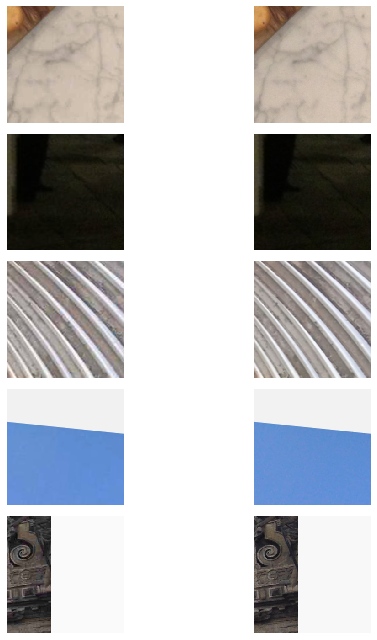

In [19]:
data.show_batch(rows=5, figsize=(9,9))

In [20]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [21]:
base_loss = F.l1_loss
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [22]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [23]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [24]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [25]:
y_range = (-3.,3.)

In [26]:
wd = 1e-3
learn_gen = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     self_attention=True, y_range=y_range,blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


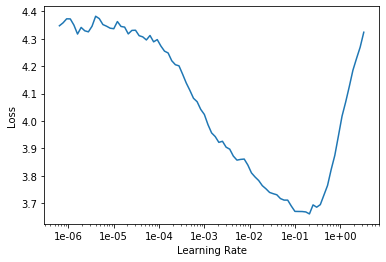

In [27]:
learn_gen.lr_find()
learn_gen.recorder.plot()

In [46]:
lr = 1e-3

In [47]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn_gen.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn_gen.save(save_name)
    learn_gen.show_results(rows=4, imgsize=5)

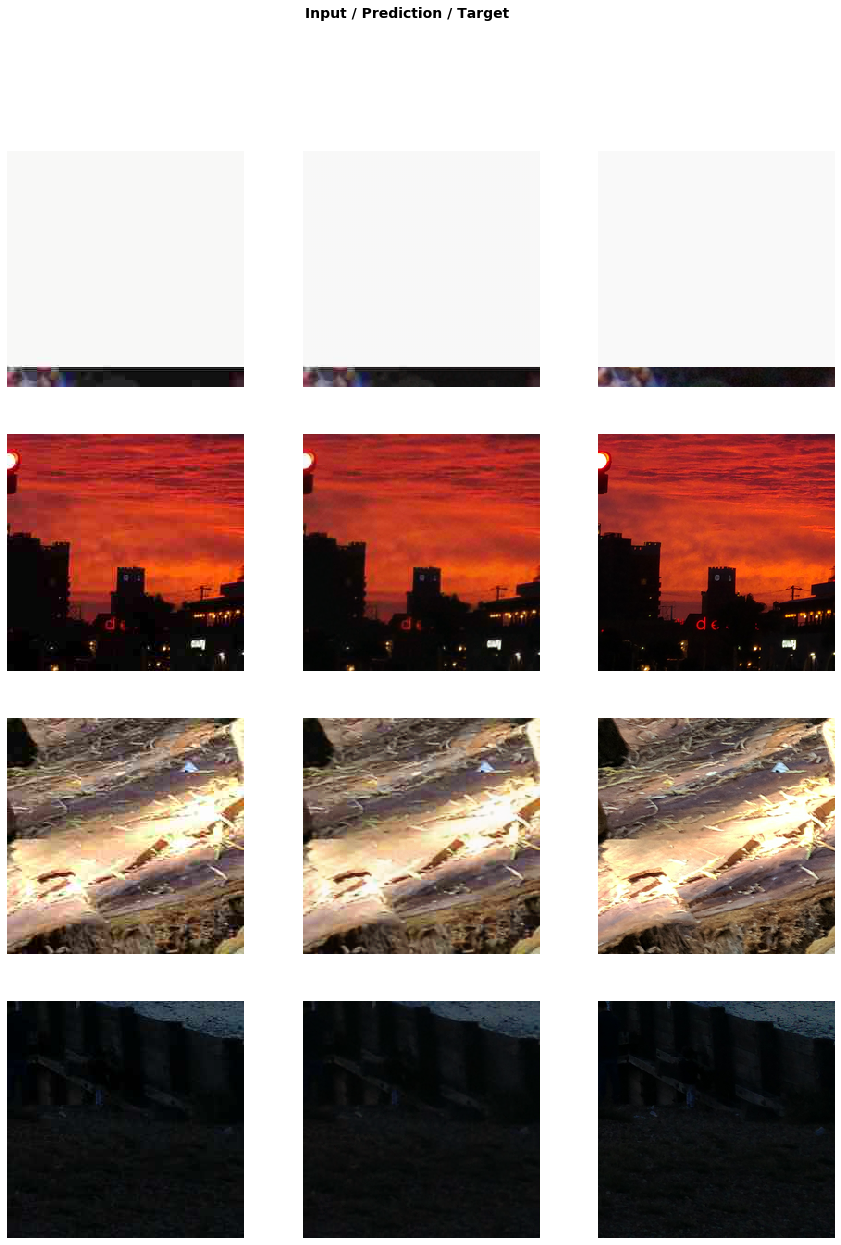

In [48]:
do_fit('1a', slice(lr*10))

In [49]:
learn_gen.unfreeze()

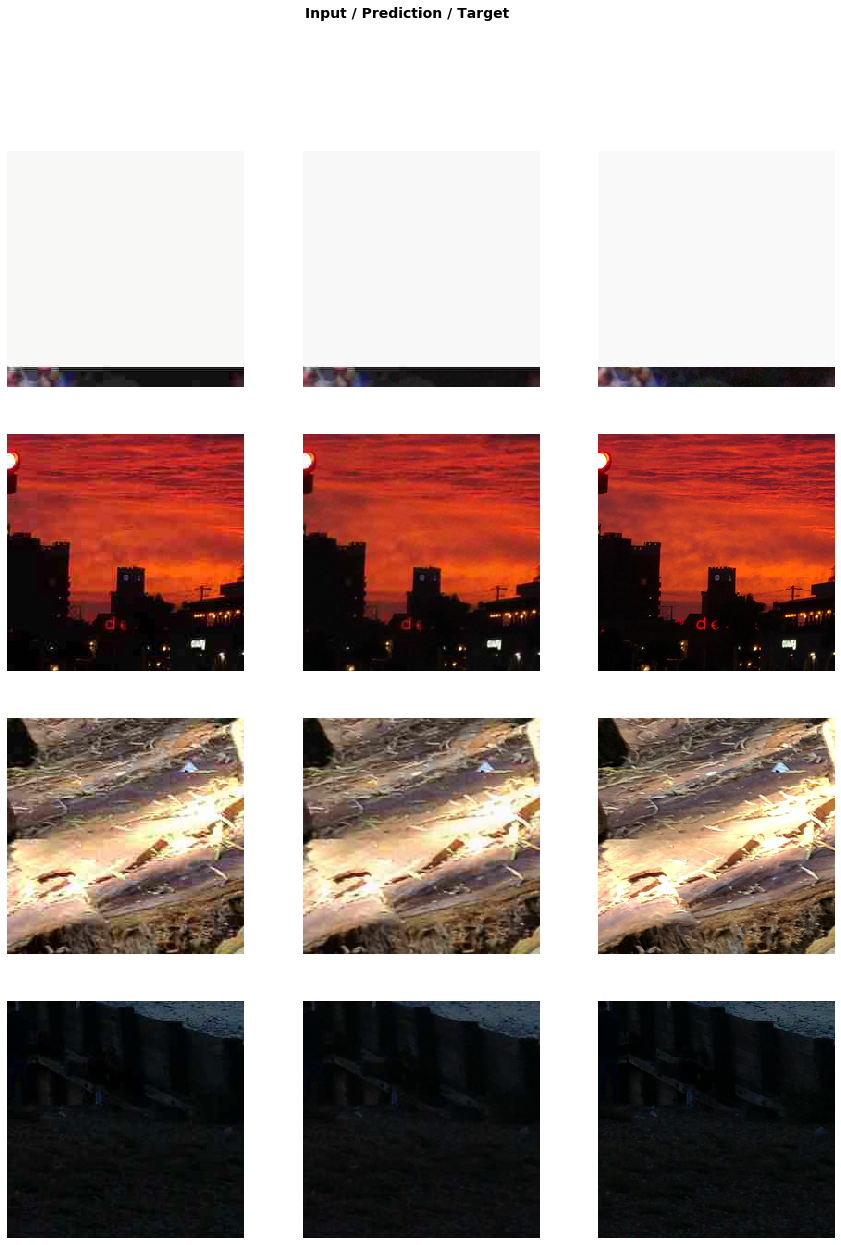

In [50]:
do_fit('1b', slice(1e-6,lr))

In [51]:
data = get_data(image_tile, src,16,size)

In [52]:
learn_gen.data = data
learn_gen.freeze()
gc.collect()

307

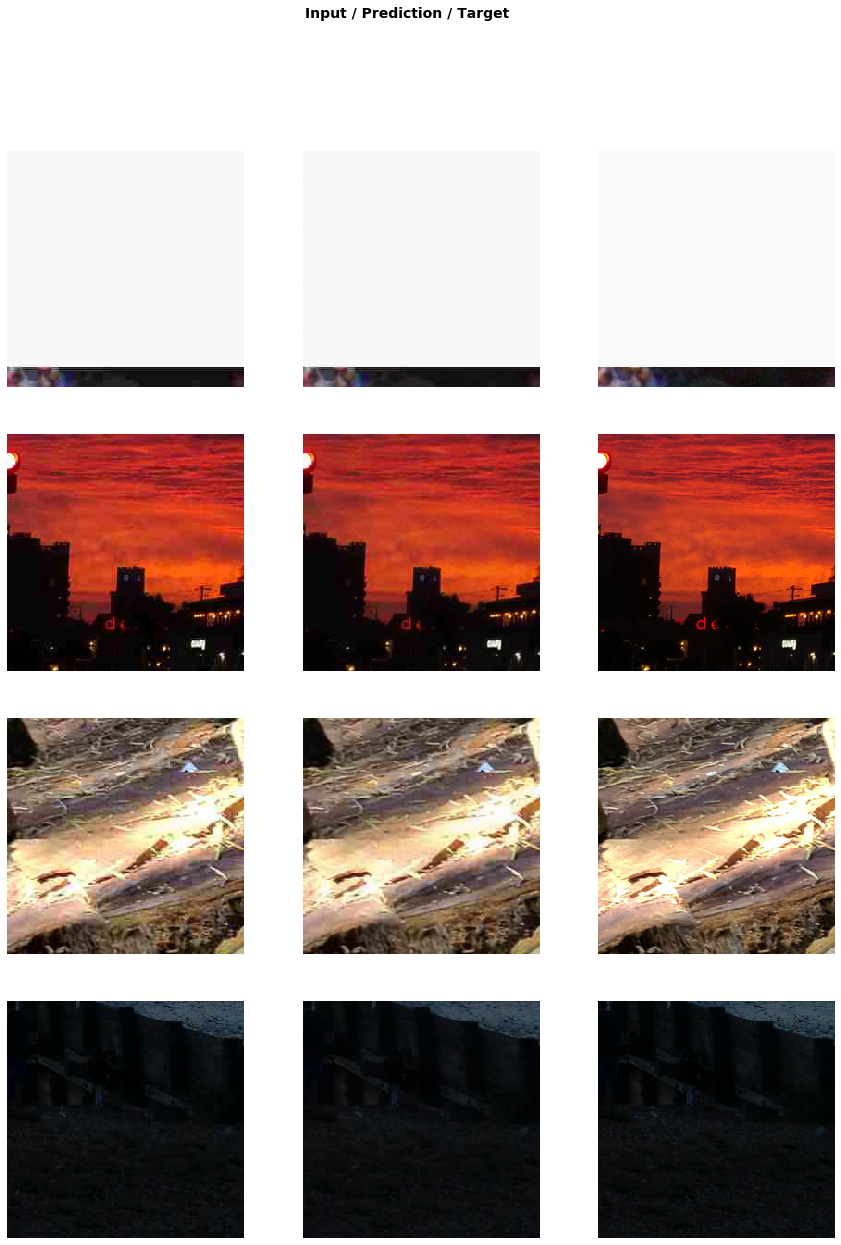

In [53]:
do_fit('2a')

In [54]:
learn.unfreeze()

In [55]:
learn_gen.unfreeze()

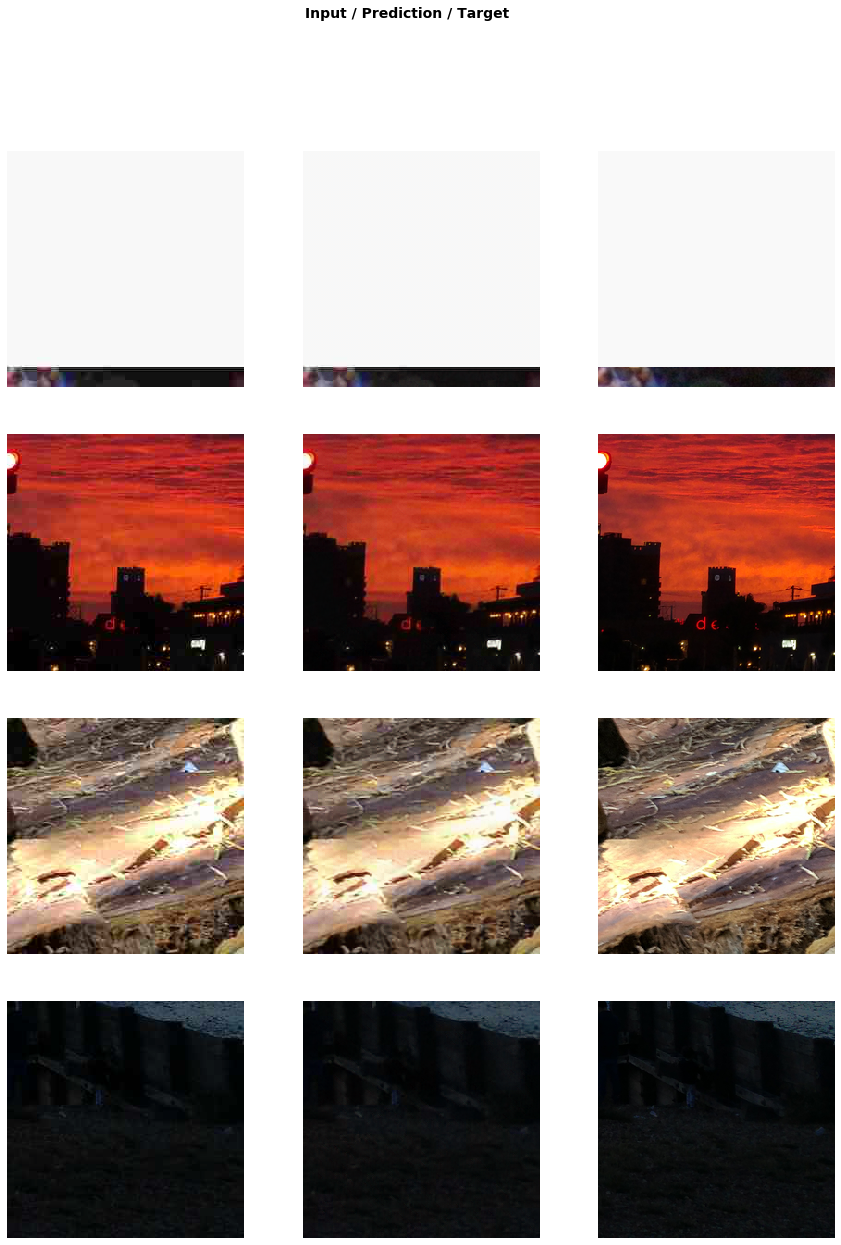

In [56]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

In [65]:
learn_gen1 = learn_gen.load('2b')

In [58]:
name_gen = 'image_gen'

path_gen = Path('../Google-Data/GGAN/image_gen')

In [59]:
path_gen.mkdir(exist_ok=True)

In [31]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [61]:
save_preds(testdata.fix_dl)

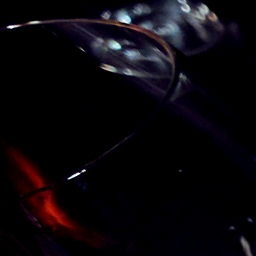

In [62]:
PIL.Image.open(path_gen.ls()[2])


In [63]:
gen_tiles = path_gen.ls(); len(gen_tiles)

1759

In [70]:
unetPred = Path('../Google-Data/GGAN/unetPred')
#Save recombined images
def save(path, output, file_stem, test_image):
    m = re.findall(r"\d+", file_stem)
    #print('file stem:', file_stem, '\n m:', m)
    result = torch.cat(output,0); 
    result = torch.reshape(result, (int(m[0])+1, int(m[1])+1, 3, 256, 256))
    new_img = reconstruct_image_from_patches(result)
    Image(new_img).save(path/f'gen_{test_image.stem}.png')

In [73]:
#Take predictions and recombine into large images
def jigsaw(saveFolder, origFolder, filePath):
    from fastai.vision.image import Image
    output = []
    file_stem = ""
    count = 0
    if not os.path.exists(saveFolder):
        os.makedirs(saveFolder)
    for i in range(0,len(origFolder)):
        output = []
        count = 0
        for file in filePath:
            if origFolder[i].stem in file.stem:
                output.append(open_image(file).data)
                count += 1
                file_stem = file.stem
        if count > 2 and count <=100:  
            #print(count)
            save(saveFolder, output, file_stem, origFolder[i])
        elif count <= 2:
            print('another pic')
            img = open_image(gen_fpath)
            img.save(saveFolder/f'gen_{origFolder[i].stem}.png')
        elif count >100:
            img = open_image(origFolder[i])
            n_chan, w, h = img.shape
            result = torch.cat(output,0);
            result = torch.reshape(result, ((w//256)+1, (h//256)+1, 3, 256, 256))
            new_img = reconstruct_image_from_patches(result)
            Image(new_img).save(saveFolder/f'gen_{origFolder[i].stem}.png')

In [79]:
gen_tiles = natsorted(gen_tiles)
gen_tileStr = [str(x) for x in gen_tiles]
gen_tileStr = natsorted(gen_tileStr)
gen_tileStr = [Path(x) for x in gen_tileStr]

In [80]:
from fastai.vision.image import Image
jigsaw(unetPred, test_images, gen_tileStr)

[tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9882]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1

In [82]:
def test_resolution(fn, i, path, q):
    dest = path/fn.relative_to(test_tile)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)  
    img.save(dest,"JPEG", quality=q)

In [83]:
#Folder to store the tiled images compressed at different qualities
if not test_compress10.exists(): 
    parallel(partial(test_resolution, path = test_compress10, q = 10), tl.items)
if not test_compress30.exists(): 
    parallel(partial(test_resolution, path = test_compress30, q =30), tl.items)
if not test_compress50.exists(): 
    parallel(partial(test_resolution, path = test_compress50, q =50), tl.items)
if not test_compress70.exists(): 
    parallel(partial(test_resolution, path = test_compress70, q =70), tl.items)


In [78]:
#Folders to store predictions of different compressed tiled images
pred_compress10 = Path('../Google-Data/GGAN/predTileCompress10')
pred_compress30 = Path('../Google-Data/GGAN/predTileCompress30')
pred_compress50 = Path('../Google-Data/GGAN/predTileCompress50')
pred_compress70 = Path('../Google-Data/GGAN/predTileCompress70')


In [87]:
#Interim folder to store predicted tiles before they are put back together
path_gen = Path('../Google-Data/GGAN/compressInterim')

In [88]:
predList = [(test_compress10,pred_compress10),(test_compress30,pred_compress30),(test_compress50,pred_compress50),(test_compress70,pred_compress70)]

In [89]:
#predict tiles, save predictions temporarily then combine into full image and save it
for compressPath, folderPath in predList:
    compressPosix = compressPath.ls()
    testsrc = ImageImageList.from_folder(compressPath).split_none()
    testData = get_data(test_tile, testsrc, bs, size)
    #Interim folder to store predicted tiles before they are put back together
    path_gen = Path('../Google-Data/GGAN/compressInterim')
    import shutil
    shutil.rmtree(path_gen)
    if not os.path.exists(path_gen):
        print('Created predictions folder')
        path_gen.mkdir(exist_ok=True)
    print('Saving Predictions')
    save_preds(testdata.fix_dl)
    gen_tiles = path_gen.ls();
    gen_tileStr = [str(x) for x in gen_tiles]
    gen_tileStr = natsorted(gen_tileStr)
    gen_tileStr = [Path(x) for x in gen_tileStr]
    print('Jigsaw Together')
    jigsaw(folderPath, test_images, gen_tileStr)


Created predictions folder
Saving Predictions
Jigsaw Together
[tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9882]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.00

Created predictions folder
Saving Predictions
Jigsaw Together
[tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9882]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.00

Created predictions folder
Saving Predictions
Jigsaw Together
[tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9882]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.00

Created predictions folder
Saving Predictions
Jigsaw Together
[tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9882]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.00

In [77]:
#Folders to combine the compressed files and save as large images
full_compress10 = Path('../Google-Data/GGAN/fullTileCompress10')
full_compress30 = Path('../Google-Data/GGAN/fullTileCompress30')
full_compress50 = Path('../Google-Data/GGAN/fullTileCompress50')
full_compress70 = Path('../Google-Data/GGAN/fullTileCompress70')


In [93]:
testList = [(test_compress10,full_compress10),(test_compress30,full_compress30),(test_compress50,full_compress50),(test_compress70,full_compress70)]
for testTilePath, savePath in testList:
    gen_tiles = testTilePath.ls()
    gen_tileStr = [str(x) for x in gen_tiles]
    gen_tileStr = natsorted(gen_tileStr)
    gen_tileStr = [Path(x) for x in gen_tileStr]
    print('Jigsaw Together')
    jigsaw(savePath, test_images, gen_tileStr)


Jigsaw Together
Jigsaw Together
Jigsaw Together
Jigsaw Together


In [82]:
#Recombine tile photos for comparison with predicted counterparts. 
#Necessary as the predicted images have been padded and are not the same size as original
full_compare = Path('../Google-Data/GGAN/fullTile')
#Recombine test images that were compressed within the range of 10-70
full_compress = Path('../Google-Data/GGAN/fullCompress')

In [244]:
gen_tiles = test_compress.ls()
gen_tileStr = [str(x) for x in gen_tiles]
gen_tileStr = natsorted(gen_tileStr)
gen_tileStr = [Path(x) for x in gen_tileStr]
jigsaw(full_compare, test_images, gen_tileStr)
jigsaw(full_compress, test_images, gen_tileStr)

In [28]:
name_gen = 'image_gen'
learn_gen = learn_gen.load('2b')
path_gen = Path('../Google-Data/GGAN/image_gen')
if os.path.exists(path_gen):
    shutil.rmtree(path_gen)
    print('Recreated predictions folder')
    path_gen.mkdir(exist_ok=True)
if not os.path.exists(path_gen):
    print('Created predictions folder')
    path_gen.mkdir(exist_ok=True)

Recreated predictions folder


In [32]:
save_preds(data.fix_dl)

In [35]:
learn_gen=None
gc.collect()

40

In [36]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [45]:
data_crit = get_crit_data([name_gen, 'imageTile'], bs=16, size=size)

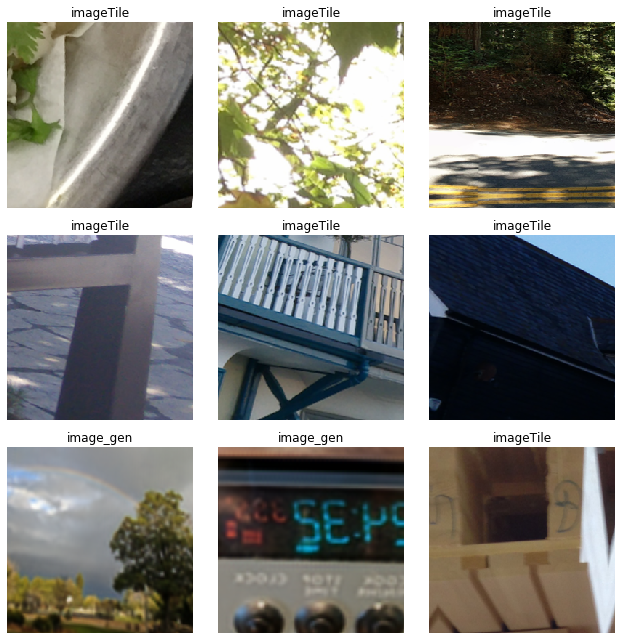

In [46]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [47]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [48]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [ ]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [50]:
learn_critic.fit_one_cycle(20, 1e-3)

KeyboardInterrupt: 

In [52]:
learn_critic.save('critic-pre2')

In [53]:
learn_crit=None
learn_gen=None
gc.collect()

48

In [54]:
bs = 4

In [55]:
data_crit = get_crit_data(['compressTile', 'imageTile'], bs=bs, size=size)

In [56]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [57]:
def create_gen_learner():
    return unet_learner(data, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=feat_loss, callback_fns=LossMetrics)

In [58]:
learn_gen = create_gen_learner().load('2b')

In [59]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


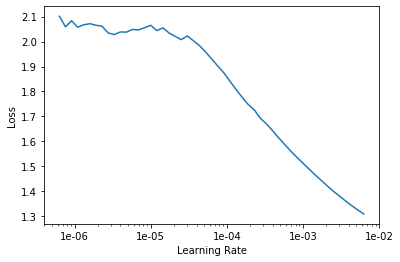

In [60]:
learn.lr_find()
learn.recorder.plot()

In [61]:
lr = 1e-4

In [62]:
learn.fit(40,lr)

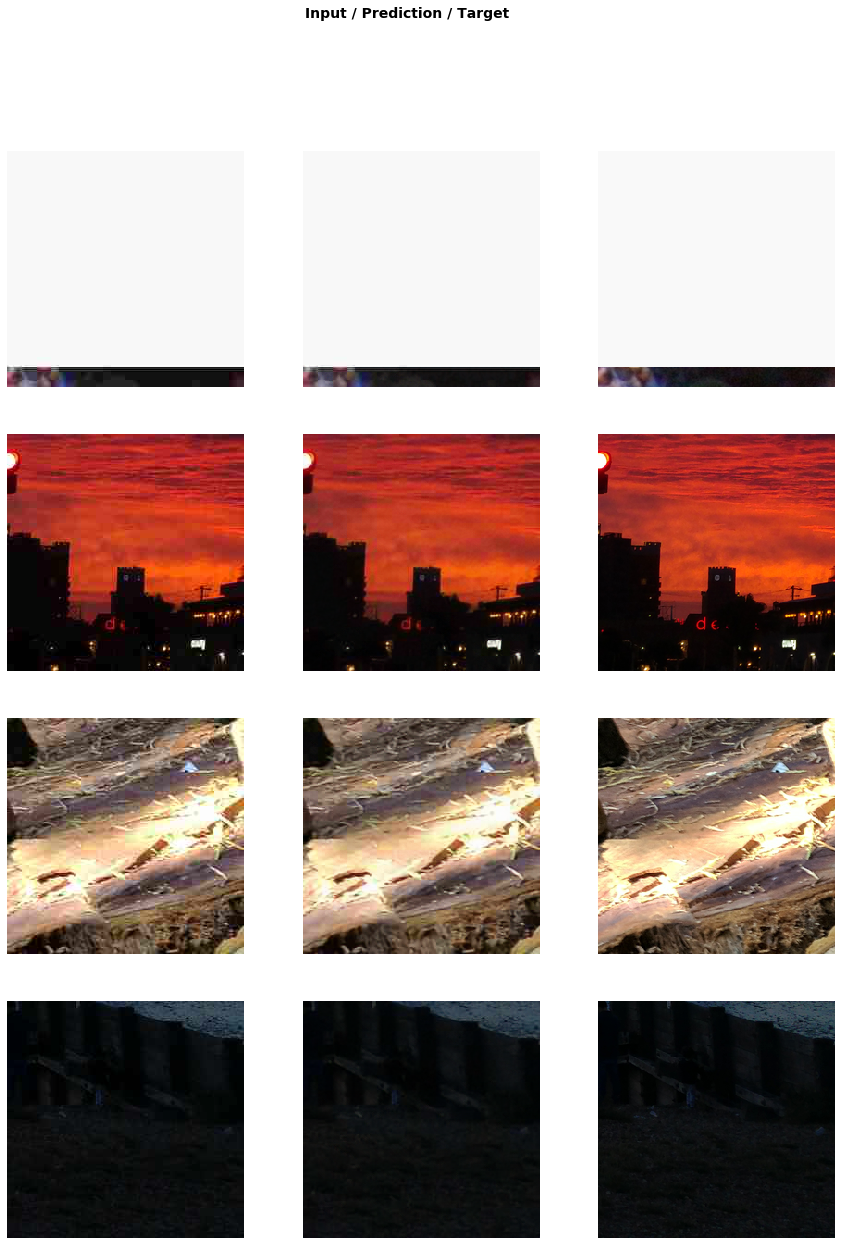

In [64]:
learn_gen.show_results(rows=4, imgsize=5)

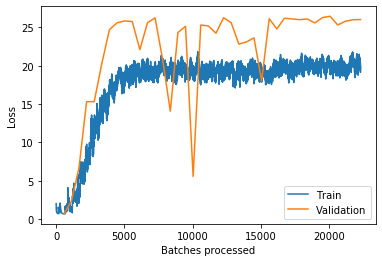

In [99]:
learn.recorder.plot_losses()

In [67]:
#Folders to store predictions of different compressed tiled images from the GAN
GAN_compress10 = Path('../Google-Data/GGAN/predGANCompress10')
GAN_compress30 = Path('../Google-Data/GGAN/predGANCompress30')
GAN_compress50 = Path('../Google-Data/GGAN/predGANCompress50')
GAN_compress70 = Path('../Google-Data/GGAN/predGANCompress70')


In [68]:
predGANList = [(test_compress10,GAN_compress10),(test_compress30,GAN_compress30),(test_compress50,GAN_compress50),(test_compress70,GAN_compress70)]

In [74]:
#predict tiles, save predictions temporarily then combine into full image and save it
for compressPath, folderPath in predGANList:
    compressPosix = compressPath.ls()
    testsrc = ImageImageList.from_folder(compressPath).split_none()
    testData = get_data(test_tile, testsrc, bs, size)
    #Interim folder to store predicted tiles before they are put back together
    path_gen = Path('../Google-Data/GGAN/compressInterim')
    if os.path.exists(path_gen):
        import shutil
        shutil.rmtree(path_gen)
   
    print('Created predictions folder')
    path_gen.mkdir(exist_ok=True)
    print('Saving Predictions')
    save_preds(testdata.fix_dl)
    gen_tiles = path_gen.ls();
    gen_tileStr = [str(x) for x in gen_tiles]
    gen_tileStr = natsorted(gen_tileStr)
    gen_tileStr = [Path(x) for x in gen_tileStr]
    print('Jigsaw Together')
    from fastai.vision.image import Image
    jigsaw(folderPath, test_images, gen_tileStr)


Created predictions folder
Saving Predictions
Jigsaw Together
Created predictions folder
Saving Predictions
Jigsaw Together
Created predictions folder
Saving Predictions
Jigsaw Together
Created predictions folder
Saving Predictions
Jigsaw Together


In [75]:
from sewar.full_ref import mse, ssim
from skimage.measure import compare_mse, compare_ssim
import cv2


In [80]:
GANPred = Path('../Google-Data/GGAN/GANPred')

In [ ]:
testsrc = ImageImageList.from_folder(test_compress).split_none()
testData = get_data(test_tile, testsrc, bs, size)
#Interim folder to store predicted tiles before they are put back together
path_gen = Path('../Google-Data/GGAN/compressInterim')
if os.path.exists(path_gen):
    import shutil
    shutil.rmtree(path_gen)

print('Created predictions folder')
path_gen.mkdir(exist_ok=True)
print('Saving Predictions')
save_preds(testdata.fix_dl)
gen_tiles = path_gen.ls();
gen_tileStr = [str(x) for x in gen_tiles]
gen_tileStr = natsorted(gen_tileStr)
gen_tileStr = [Path(x) for x in gen_tileStr]
print('Jigsaw Together')
jigsaw(GANPred, test_images, gen_tileStr)

In [83]:
measureList = [('U-Net pred of images compressed at 10',pred_compress10),('U-Net pred of images compressed at 30',pred_compress30),
('U-Net pred of images compressed at 50',pred_compress50),('U-Net pred of images compressed at 70',pred_compress70),
('Original images compressed at 10', full_compress10),('Original images compressed at 30', full_compress30),
('Original images compressed at 50', full_compress50),('Original images compressed at 70', full_compress70),
('GAN pred of images compressed at 10',GAN_compress10),('GAN pred of images compressed at 30',GAN_compress30),
('GAN pred of images compressed at 50',GAN_compress50),('GAN pred of images compressed at 70',GAN_compress70),
('U-Net pred of images compressed at 10 - 70',unetPred),('GAN pred of images compressed at 10 - 70',GANPred),
('Original images compressed at 10 - 70',full_compress)]
results = []
full_compare = Path('../Google-Data/GGAN/fullTile')
FullOrig = full_compare.ls()
for fileString, fileFolder in measureList:
    filePaths = fileFolder.ls()
    mse = 0
    ssim = 0
    count = 0
    for i in range(0,len(FullOrig)):
        for file in filePaths:
            if FullOrig[i].stem in file.stem:
                pred = cv2.imread(str(file))
                orig = cv2.imread(str(FullOrig[i]))
                mse += compare_mse(orig,pred)
                ssim += compare_ssim(orig,pred,multichannel=True)
                count += 1
    print(fileString + ' average mse: ', mse/count)
    print(fileString + ' average ssim: ', ssim/count)
    results.append((fileString + ' average mse: ', mse/count))
    results.append((fileString + ' average ssim: ', ssim/count))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


U-Net pred of images compressed at 10 average mse:  196.10539637889178
U-Net pred of images compressed at 10 average ssim:  0.8607227021293672
U-Net pred of images compressed at 30 average mse:  196.10539637889178
U-Net pred of images compressed at 30 average ssim:  0.8607227021293672
U-Net pred of images compressed at 50 average mse:  196.10539637889178
U-Net pred of images compressed at 50 average ssim:  0.8607227021293672
U-Net pred of images compressed at 70 average mse:  196.10539637889178
U-Net pred of images compressed at 70 average ssim:  0.8607227021293672
Original images compressed at 10 average mse:  112.10478663614819
Original images compressed at 10 average ssim:  0.7883913074574297
Original images compressed at 30 average mse:  46.71366183748321
Original images compressed at 30 average ssim:  0.8880633046638133
Original images compressed at 50 average mse:  31.520367855685098
Original images compressed at 50 average ssim:  0.9171457726894198
Original images compressed at 

In [98]:
with open('ur file.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['name','result'])
    for row in results:
        csv_out.writerow(row)
